In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint
seed = 0

sns.set_style('whitegrid')

In [3]:
def shape(down,up,plug_in):
    return (up-plug_in)/(plug_in-down)

def length(down, up):
    return up-down

def bootstrapped_statistics(x_stars, statistic):
    thetas = np.empty(len(x_stars))
    for i,x_star in enumerate(x_stars):
        thetas[i] = statistic(x_star)
    return thetas

def bootstrap_samples(sampling_distribution, X, B):
    X_star = np.empty(shape=(B,len(X)))
    for i in range(B):
        X_star[i] = X[sampling_distribution.rvs(size=len(X))]
    return X_star

In [4]:
def jacknife_samples(X):
    arr = []
    for i in range(len(X)):
        arr.append(np.append(X[:i], X[i+1:]))
    return np.array(arr)

def acceleration(shanked_statistics):
    n = len(shanked_statistics)
    shanked_mean = shanked_statistics.mean()*np.ones(n)
    denominator = np.sum((shanked_mean-shanked_statistics)**3)
    nominator = (np.sum((shanked_mean-shanked_statistics)**2)**(3/2))*6
    return denominator/nominator

from statistics import NormalDist
def bias_correction(boostrapped_stats, plug_in_estimation, B):
    logic_arr = boostrapped_stats < plug_in_estimation
    return NormalDist(mu=0, sigma=1).inv_cdf(np.sum(logic_arr)/B)

def BCa_alphas(z_0, acc, alpha):
    standard_normal = NormalDist(mu=0, sigma=1)
    alpha_one = standard_normal.cdf(z_0+(z_0+standard_normal.inv_cdf(alpha/2))/(1-acc*(z_0+standard_normal.inv_cdf(alpha/2))))
    alpha_two = standard_normal.cdf(z_0+(z_0+standard_normal.inv_cdf(1-alpha/2))/(1-acc*(z_0+standard_normal.inv_cdf(1-alpha/2))))
    return alpha_one, alpha_two

def BCa_interval(X, bootstrap_samples, statistic, alpha):
    X_star = bootstrap_samples
    X_hat = statistic(X)
    T_star = np.array(list(map(lambda x: statistic(x), X_star)))
    T_star = np.sort(T_star)
    B = len(X_star)
    shanked_samples = jacknife_samples(X)
    acc = acceleration(np.array(list(map(lambda x: statistic(x), shanked_samples))))
    z_0 = bias_correction(T_star, X_hat, B)
    alpha_1, alpha_2 = BCa_alphas(z_0, acc, alpha)
    return T_star[int(B*alpha_1//1)], T_star[int(B*alpha_2//1)]

In [5]:
def bhm(data=None,T=20,k=30,m=10):
    all_samples = []
    for i in range(T*k):
        indexes = np.random.randint(low=0, high=len(data), size=m)
        all_samples.append(data[indexes])

    all_samples = np.array(all_samples)
    all_data = all_samples.reshape(all_samples.shape[0]*all_samples.shape[1])

    theta_mean = all_data.mean()
    s = all_data.std()
    
    ds_arr = []
    for i in range(T*k):
        d_i = []
        if i!=0 and i%k==0:
            ds_arr.append(d_i)
            d_i = []
        else:
            d_i.append(all_samples[i])
    
    lb, ub = BCa_interval(all_data, all_samples, lambda x: x.mean(), alpha=0.05)

    theta_t = theta_mean
    thetas = [theta_mean]
    acceptances = []
    for ds in ds_arr:
        #draw v from N(theta_t, s^2)
        v = np.random.normal(loc=theta_t,scale=s*0.5,size=None)
        f_di_v = 1
        f_di_theta = 1
        for di in ds:
            for xj in di:
                f_di_v*= np.exp(-((xj-v)**2)/(2*s**2))/(s*np.sqrt(2*np.pi))
                f_di_theta*= np.exp(-((xj-theta_t)**2)/(2*s**2))/(s*np.sqrt(2*np.pi))
        aux_1 = (f_di_v/f_di_theta)**(1/k)
        aux_2 = theta_t/v
        aux_3 = (s*0.5/s)*np.exp((theta_t-v)**2*(1/s**2-1/(s*0.5)**2)/2)
        acceptance = np.min([1,aux_1*aux_2*aux_3])
        prob = np.random.binomial(1,acceptance)
        theta_t = v*prob + theta_t*(1-prob)

        thetas.append(theta_t)
        acceptances.append(acceptance)
    
    return thetas, acceptances


In [6]:
wine = pd.read_csv('../data/winequality-red.csv')

<Axes: ylabel='Frequency'>

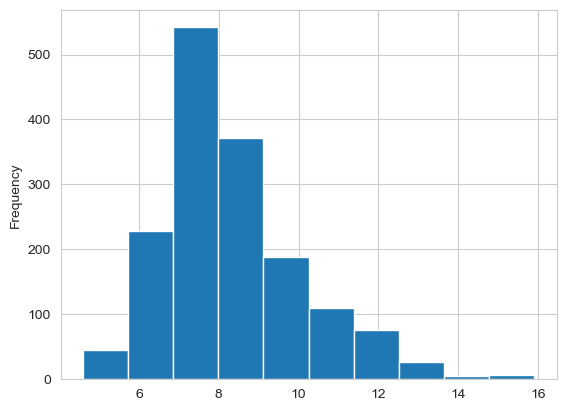

In [7]:
wine['fixed acidity'].plot(kind='hist')

In [8]:
thetas, acceptances = bhm(data=np.array(wine['fixed acidity']),T=10,k=50,m=10)

In [9]:
thetas

[8.2886,
 8.2886,
 8.2886,
 8.2886,
 8.2886,
 8.2886,
 8.2886,
 8.2886,
 8.2886,
 9.199177000881162]

c:\Users\Darius\miniconda3\envs\general_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Darius\miniconda3\envs\general_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

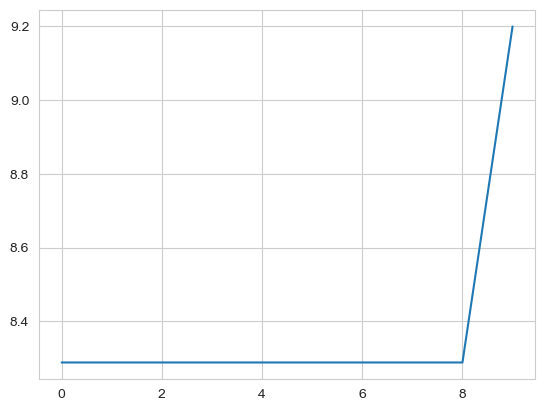

In [11]:
sns.lineplot(x=range(len(thetas)), y=thetas)

In [12]:
wine['fixed acidity'].mean()

8.31963727329581

In [13]:
acceptances

[0.48526882622574935,
 0.4295978005965362,
 0.11961549539535918,
 0.5021876548628463,
 0.31345483873948654,
 0.29615936738291176,
 0.33279104490598266,
 0.2523037288730046,
 0.29898102534023224]